[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO Object Detection on a Custom Dataset

---


## Environment setup

In [14]:
import os
from dotenv import load_dotenv

load_dotenv()  # charge .env dans os.environ
api_key = os.getenv("ROBOFLOW_API_KEY")

### Check GPU availability

In [15]:
!nvidia-smi

Sat Jun 21 12:20:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.72                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1060 3GB    On  |   00000000:01:00.0  On |                  N/A |
| 27%   66C    P8             10W /  120W |    2751MiB /   3072MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/home/jovyan/notebooks


### Install dependencies

In [16]:
!pip install roboflow supervision opencv-python ultralytics

Defaulting to user installation because normal site-packages is not writeable


### Download example data


In [17]:
!wget !wget https://vivre-de-la-photo.fr/wp-content/uploads/2021/12/auto-g23f40b856_1280.jpg

--2025-06-21 12:20:14--  http://!wget/
Resolving !wget (!wget)... failed: Name or service not known.
wget: unable to resolve host address ‘!wget’
--2025-06-21 12:20:14--  https://vivre-de-la-photo.fr/wp-content/uploads/2021/12/auto-g23f40b856_1280.jpg
Resolving vivre-de-la-photo.fr (vivre-de-la-photo.fr)... 193.37.145.81, 2a00:7ee0:1:0:3:2206:0:188
Connecting to vivre-de-la-photo.fr (vivre-de-la-photo.fr)|193.37.145.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 364649 (356K) [image/jpeg]
Saving to: ‘auto-g23f40b856_1280.jpg.1’

auto-g23f40b856_128 100%[===================>] 356.10K  --.-KB/s    in 0.08s   

2025-06-21 12:20:14 (4.61 MB/s) - ‘auto-g23f40b856_1280.jpg.1’ saved [364649/364649]

FINISHED --2025-06-21 12:20:14--
Total wall clock time: 0.2s
Downloaded: 1 files, 356K in 0.08s (4.61 MB/s)


## Run inference


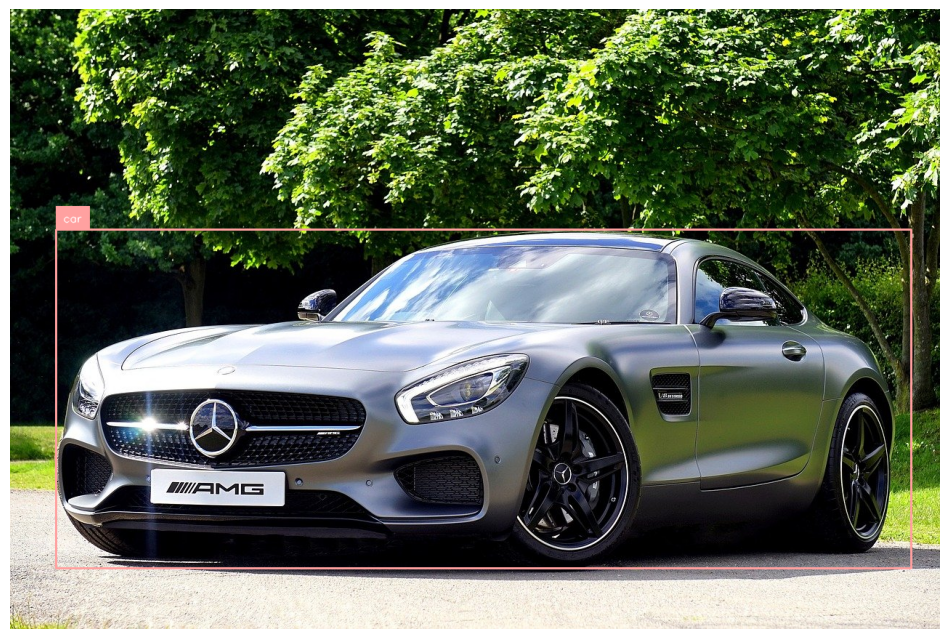

In [18]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/auto-g23f40b856_1280.jpg"
image = cv2.imread(image_path)

model = YOLO('yolov8m.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [19]:
!pip install roboflow

import getpass
from roboflow import Roboflow

api_key = getpass.getpass("Entre ta clé API Roboflow (masquée) : ")

rf = Roboflow(api_key=api_key)
project = rf.workspace("roboflow-universe-projects").project("license-plate-recognition-rxg4e")
version = project.version(11)
dataset = version.download("yolov8")

Defaulting to user installation because normal site-packages is not writeable


Entre ta clé API Roboflow (masquée) :  ········


loading Roboflow workspace...
loading Roboflow project...


In [20]:
!ls {dataset.location}

README.dataset.txt  README.roboflow.txt  data.yaml  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [21]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [22]:
!cat {dataset.location}/data.yaml

names:
- License_Plate
nc: 1
roboflow:
  license: CC BY 4.0
  project: license-plate-recognition-rxg4e
  url: https://universe.roboflow.com/roboflow-universe-projects/license-plate-recognition-rxg4e/dataset/11
-e test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLO model


In [23]:
from ultralytics import YOLO

model = YOLO('yolov8m')

results = model.train(data=f'{dataset.location}/data.yaml',  project='/home/jovyan/yolo-training', epochs=10, batch=1, patience=0, save_period=5, save=True, workers=2)

Ultralytics 8.3.157 🚀 Python-3.10.18 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce GTX 1060 3GB, 3072MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/jovyan/notebooks/License-Plate-Recognition-11/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train7, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=0, p

train: Scanning /home/jovyan/notebooks/License-Plate-Recognition-11/train/labels.cache... 7057 images, 5 backgrounds, 0 corrupt: 100% 7057/7057 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 202.6±110.7 MB/s, size: 20.8 KB)


val: Scanning /home/jovyan/notebooks/License-Plate-Recognition-11/valid/labels.cache... 2048 images, 3 backgrounds, 0 corrupt: 100% 2048/2048 [00:00<?, ?it/s]


Plotting labels to /home/jovyan/yolo-training/train7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /home/jovyan/yolo-training/train7
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.27G      1.515      1.198       1.36          1        640: 100% 7057/7057 [34:18<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1024/1024 [01:59<00:00,  8.56it/s]


                   all       2048       2195      0.822      0.717      0.772      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.27G      1.447     0.9999      1.331          1        640: 100% 7057/7057 [33:32<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1024/1024 [02:26<00:00,  6.99it/s]

                   all       2048       2195      0.868      0.774      0.844      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.27G      1.379     0.8902      1.284          1        640: 100% 7057/7057 [36:09<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1024/1024 [02:08<00:00,  7.98it/s]


                   all       2048       2195      0.877        0.8      0.865      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.27G       1.35     0.8306      1.268          1        640: 100% 7057/7057 [35:42<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1024/1024 [02:20<00:00,  7.29it/s]


                   all       2048       2195      0.882      0.826      0.884      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.27G       1.31     0.7575      1.232          1        640: 100% 7057/7057 [36:06<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1024/1024 [02:13<00:00,  7.67it/s]


                   all       2048       2195      0.855      0.786      0.867      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.27G      1.274     0.7043       1.21          1        640: 100% 7057/7057 [36:34<00:00,  3.22it/s] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1024/1024 [02:14<00:00,  7.61it/s]

                   all       2048       2195      0.933      0.821      0.902      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.27G      1.243     0.6674      1.198          1        640: 100% 7057/7057 [37:03<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1024/1024 [02:09<00:00,  7.93it/s]

                   all       2048       2195      0.942      0.822      0.913      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.27G      1.216     0.6332      1.174          1        640: 100% 7057/7057 [35:38<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1024/1024 [02:08<00:00,  8.00it/s]


                   all       2048       2195      0.942       0.84      0.922      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.27G      1.195     0.6098      1.161          1        640: 100% 7057/7057 [38:06<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1024/1024 [02:58<00:00,  5.73it/s]


                   all       2048       2195      0.955      0.839       0.92      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.27G      1.165     0.5743      1.146          1        640: 100% 7057/7057 [46:12<00:00,  2.55it/s] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1024/1024 [02:58<00:00,  5.72it/s]

                   all       2048       2195      0.945      0.861      0.934      0.632



10 epochs completed in 6.563 hours.
Optimizer stripped from /home/jovyan/yolo-training/train7/weights/last.pt, 52.0MB
Optimizer stripped from /home/jovyan/yolo-training/train7/weights/best.pt, 52.0MB

Validating /home/jovyan/yolo-training/train7/weights/best.pt...
Ultralytics 8.3.157 🚀 Python-3.10.18 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce GTX 1060 3GB, 3072MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1024/1024 [02:12<00:00,  7.74it/s]


                   all       2048       2195      0.945      0.861      0.934      0.632
Speed: 1.9ms preprocess, 39.6ms inference, 0.0ms loss, 7.4ms postprocess per image
Results saved to /home/jovyan/yolo-training/train7


## Evaluate fine-tuned YOLOv12 model

In [24]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls /home/jovyan/yolo-training/train5

F1_curve.png			 labels_correlogram.jpg  train_batch2.jpg
PR_curve.png			 results.csv		 val_batch0_labels.jpg
P_curve.png			 results.png		 val_batch0_pred.jpg
R_curve.png			 train_batch0.jpg	 val_batch1_labels.jpg
args.yaml			 train_batch1.jpg	 val_batch1_pred.jpg
confusion_matrix.png		 train_batch1980.jpg	 val_batch2_labels.jpg
confusion_matrix_normalized.png  train_batch1981.jpg	 val_batch2_pred.jpg
labels.jpg			 train_batch1982.jpg	 weights


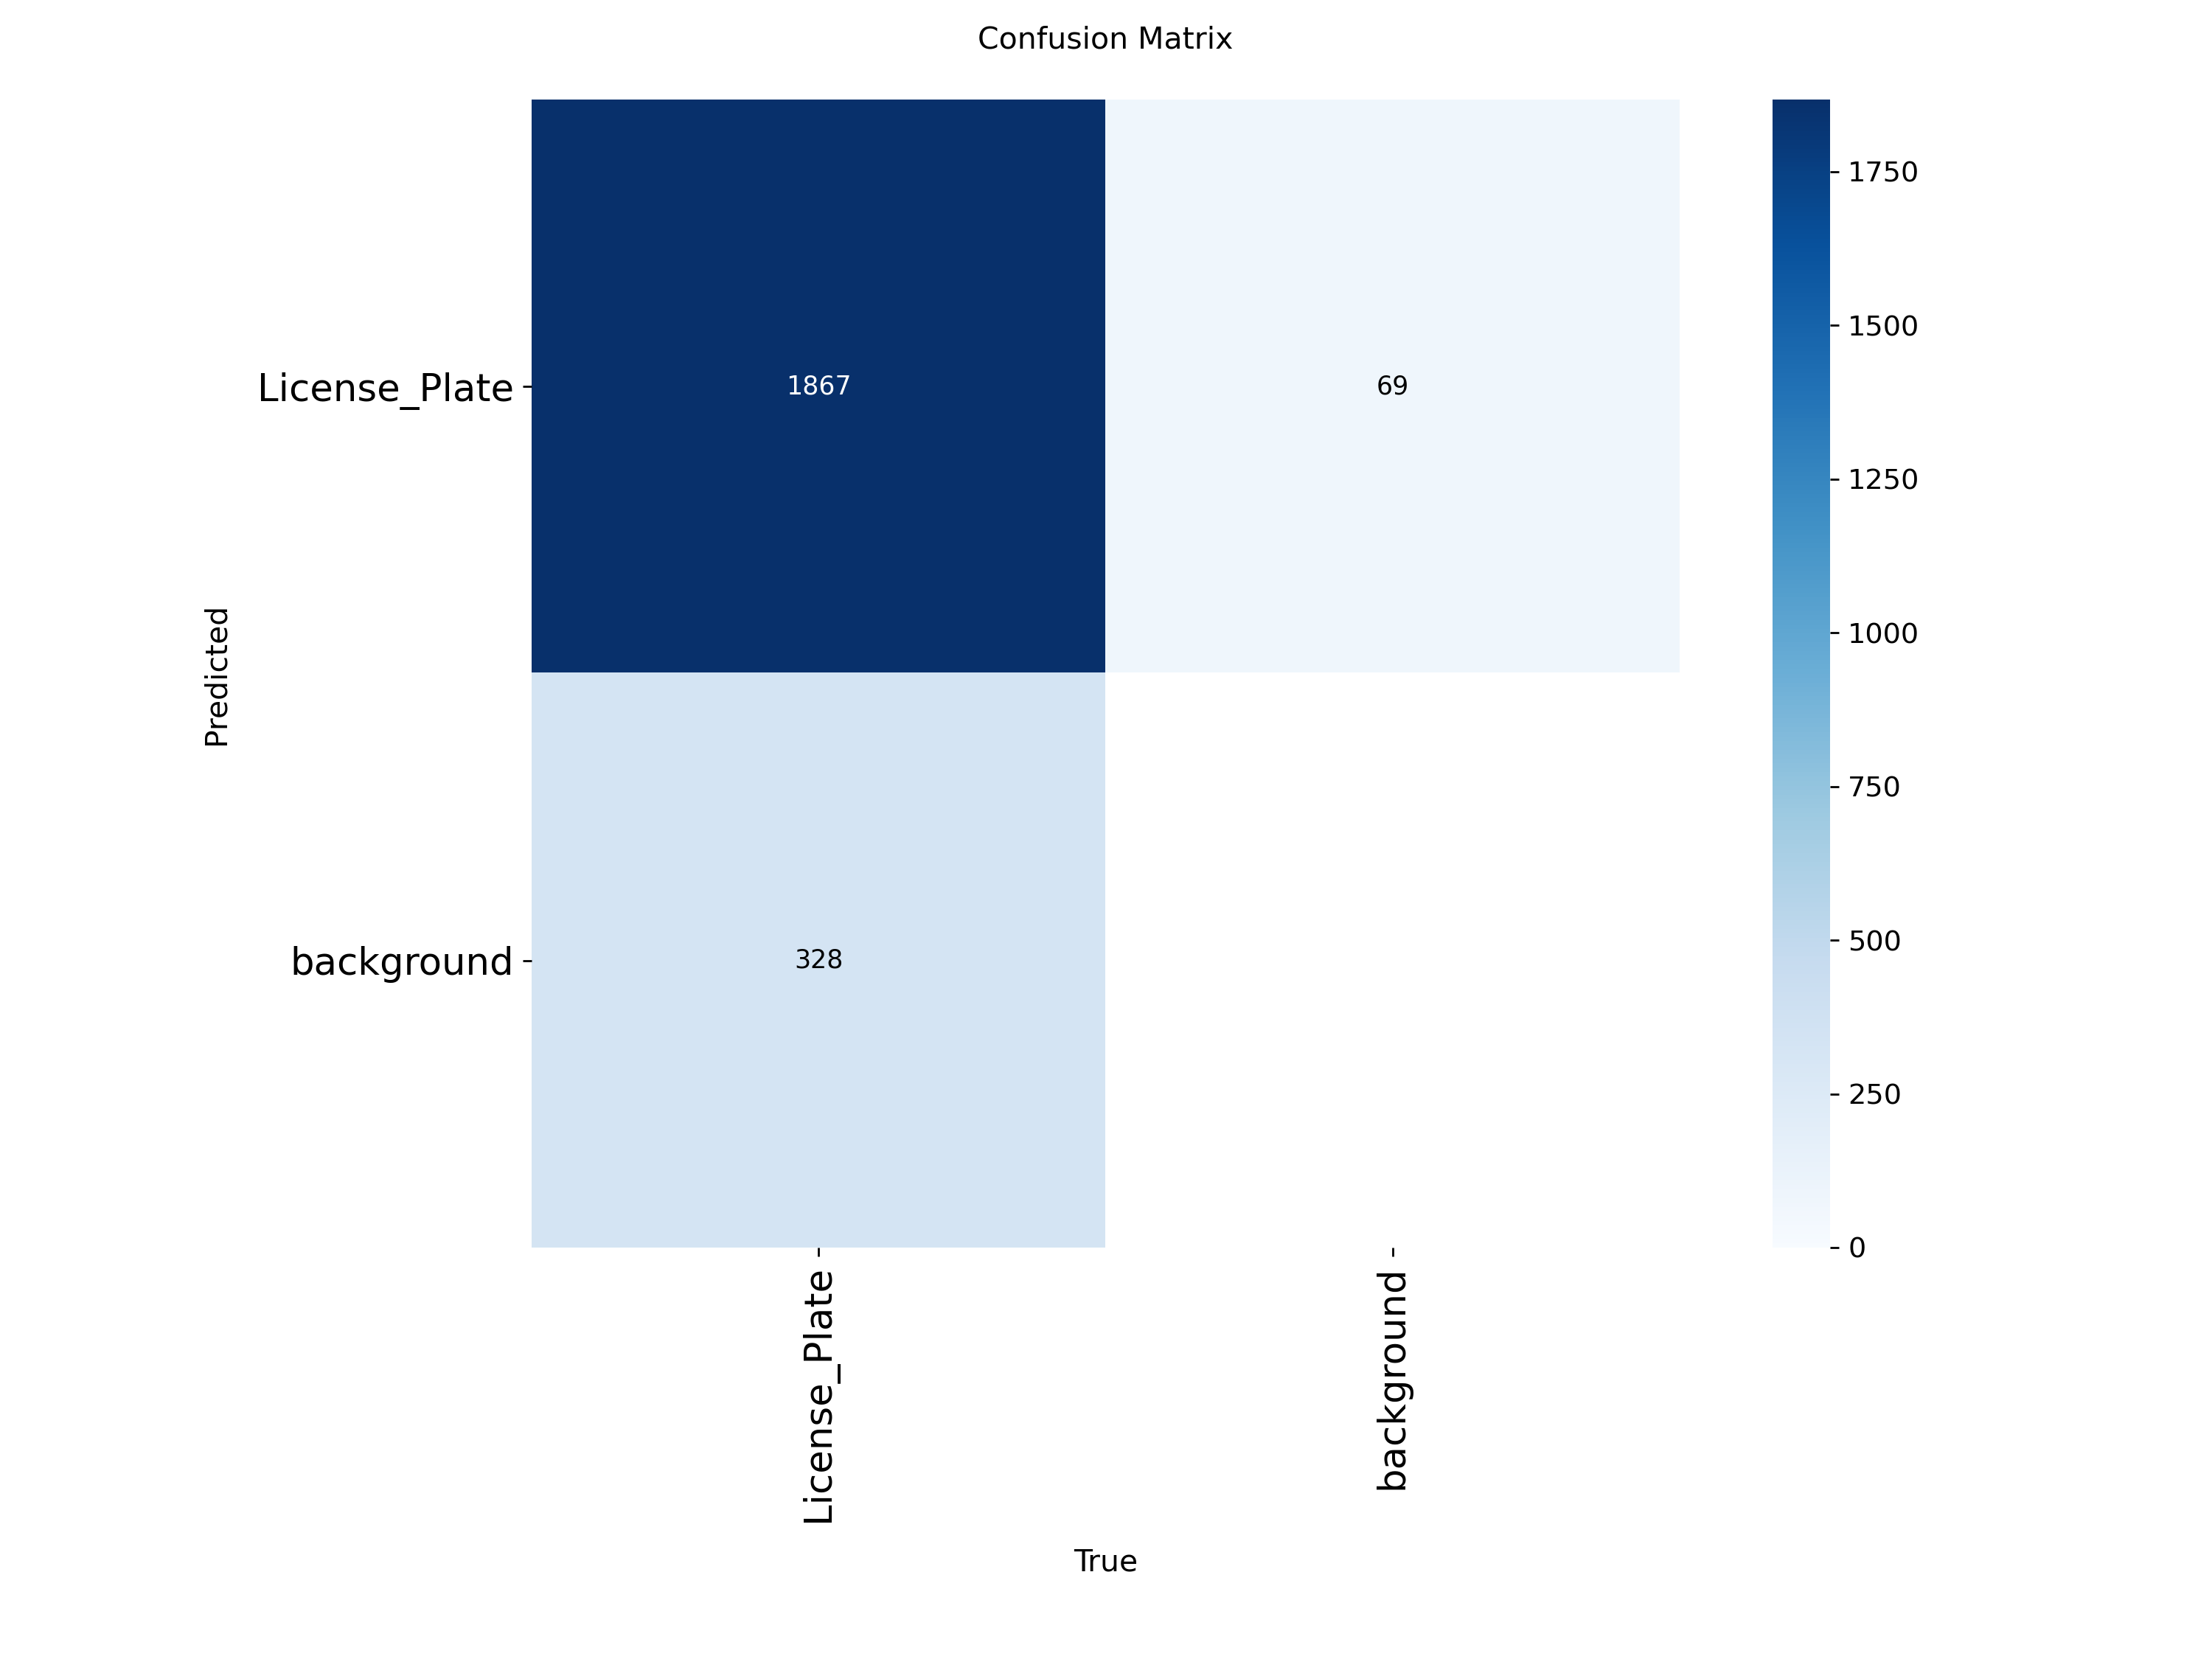

In [25]:
from IPython.display import Image

Image(filename=f'/home/jovyan/yolo-training/train7/confusion_matrix.png', width=1000)

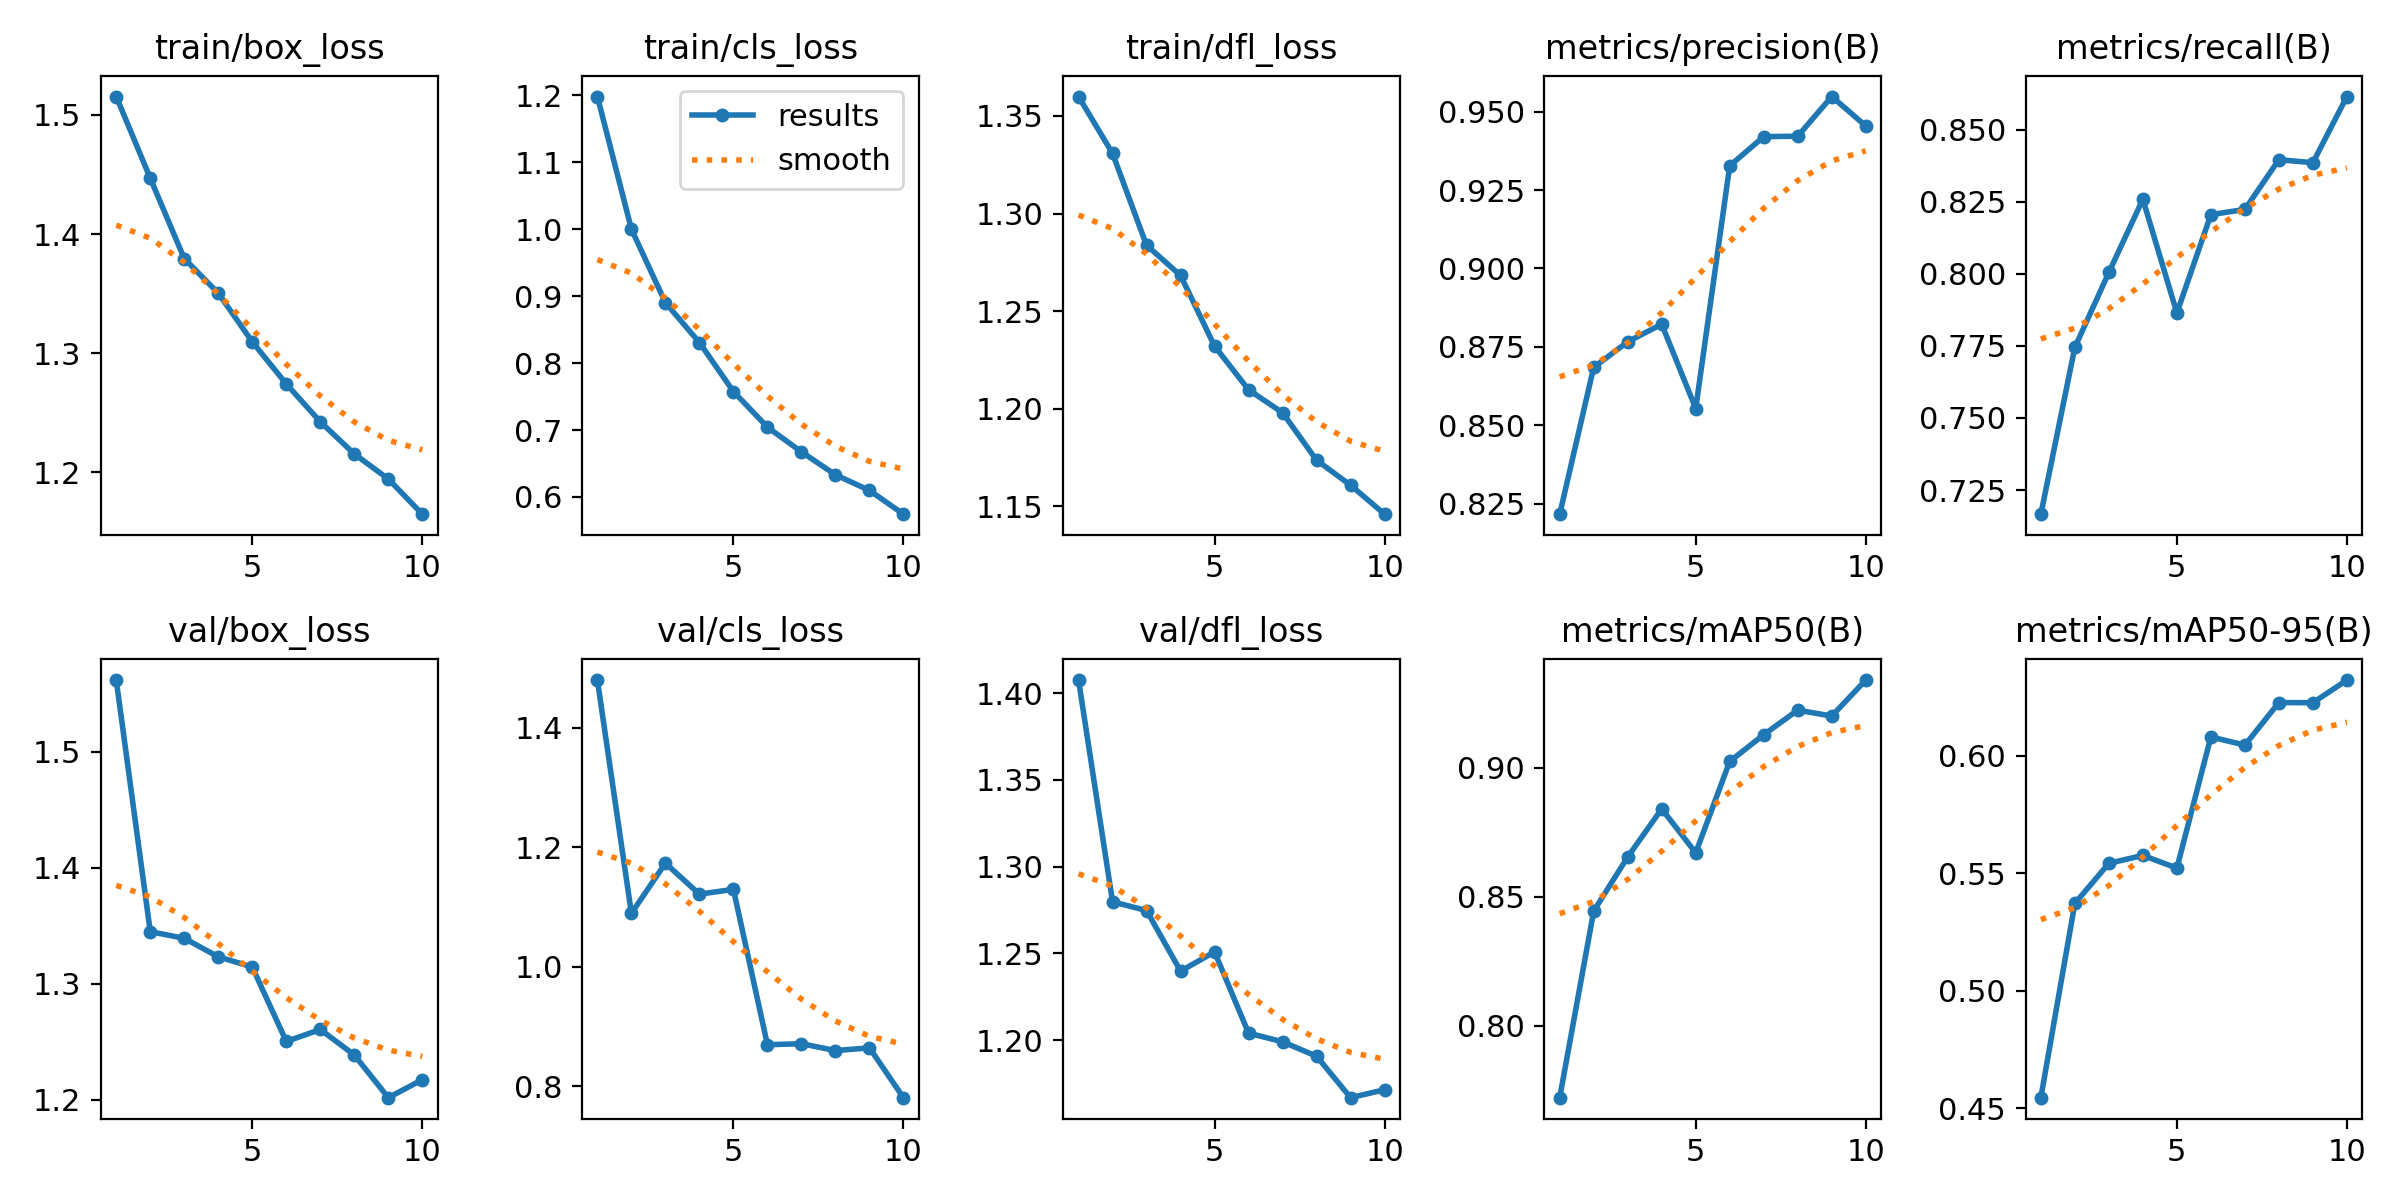

In [26]:
from IPython.display import Image

Image(filename=f'/home/jovyan/yolo-training/train7/results.png', width=1000)

In [39]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['License_Plate']

In [44]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/home/jovyan/yolo-training/train7/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [35]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.5734073626116448
mAP 50 0.8500088755740641
mAP 75 0.6832446811959711


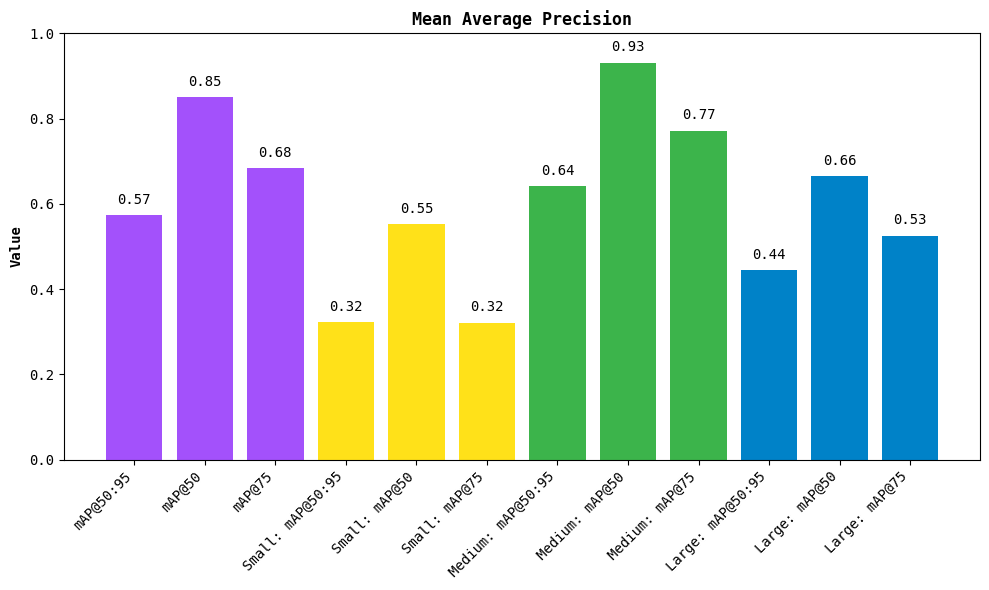

In [45]:
map.plot()

📊 Résumé des métriques
Metric	Score	Analyse
mAP@50	0.850 ✅	Très bon – ton modèle détecte bien les objets
mAP@75	0.683 ✅	Solide – tes boîtes sont de mieux en mieux ajustées
mAP@50:95	0.573 ✅	En progrès – ton modèle est globalement précis, même aux seuils élevés

🧠 Interprétation
Tu es désormais dans une zone de qualité semi-pro, avec :

bonne détection des objets (mAP@50 > 0.85)

qualité des boîtes en nette amélioration (mAP@75 > 0.68)

un mAP@50:95 suffisamment bon pour des usages concrets (webcams, robots, alertes, etc.)

Mais il reste de la marge sur la généralisation (mAP@50:95 < 0.65 → typique des erreurs sur les tailles, angles ou cas limites).

## Run inference with fine-tuned YOLO model

In [37]:
import supervision as sv

model = YOLO(f'/home/jovyan/yolo-training/train7/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

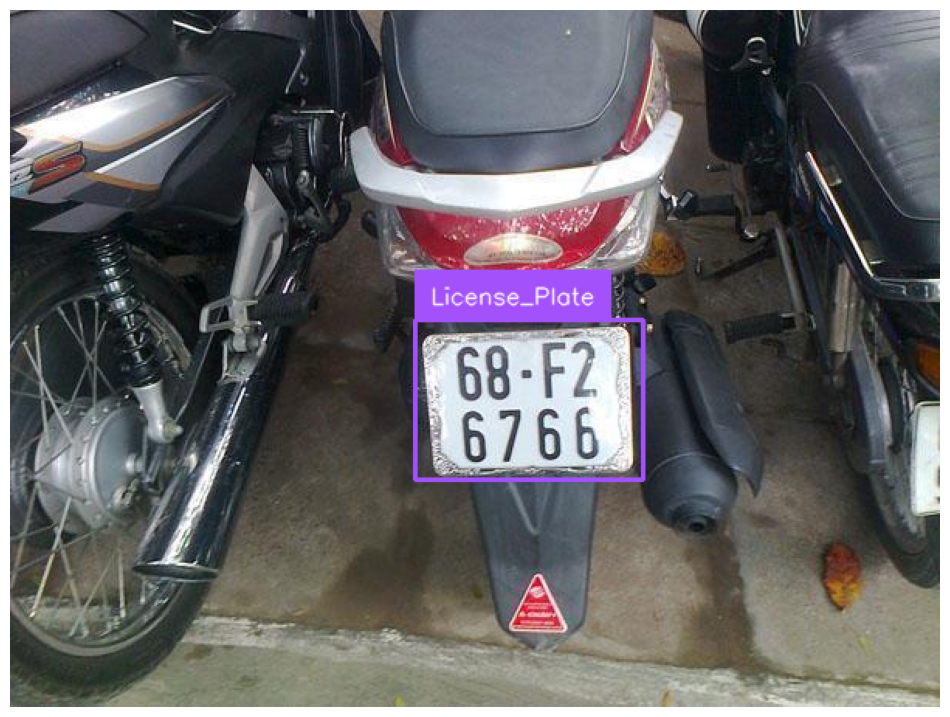

In [64]:
import random

i = random.randint(0, len(ds))


image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

--2025-06-21 20:58:57--  https://github.com/laurent-pereira/ia-face-detector/blob/master/example.jpg?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/laurent-pereira/ia-face-detector/raw/refs/heads/master/example.jpg [following]
--2025-06-21 20:58:57--  https://github.com/laurent-pereira/ia-face-detector/raw/refs/heads/master/example.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/laurent-pereira/ia-face-detector/refs/heads/master/example.jpg [following]
--2025-06-21 20:58:57--  https://raw.githubusercontent.com/laurent-pereira/ia-face-detector/refs/heads/master/example.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (

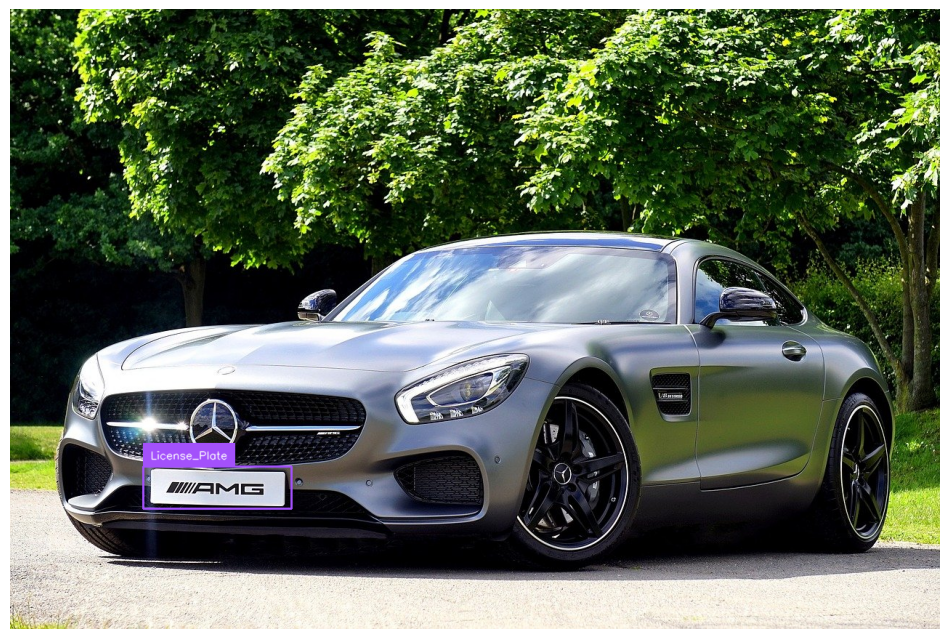

In [48]:
model = YOLO(f'/home/jovyan/yolo-training/train7/weights/best.pt')

!wget https://github.com/laurent-pereira/ia-face-detector/blob/master/example.jpg?raw=true

image_path = f"{HOME}/auto-g23f40b856_1280.jpg"
image = cv2.imread(image_path)

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)